In [15]:
!pip install shap
!pip install lime

     ---------------------------------------- 0.0/275.7 kB ? eta -:--:--
     - -------------------------------------- 10.2/275.7 kB ? eta -:--:--
     - -------------------------------------- 10.2/275.7 kB ? eta -:--:--
     ---- -------------------------------- 30.7/275.7 kB 220.2 kB/s eta 0:00:02
     -------- ---------------------------- 61.4/275.7 kB 299.4 kB/s eta 0:00:01
     ---------------- ------------------- 122.9/275.7 kB 516.7 kB/s eta 0:00:01
     ---------------------------------- - 266.2/275.7 kB 966.0 kB/s eta 0:00:01
     ---------------------------------- - 266.2/275.7 kB 966.0 kB/s eta 0:00:01
     ------------------------------------ 275.7/275.7 kB 809.4 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283842 sha256=2d52df2b085def8573046de4e04ca2a152b138d29a2ca61078e892ab4c8d5e8d
  Stored in directory: c:\users\lenovo\appdata\l

In [16]:
!pip install scikit-optimize

# 1. Data Preprocessing and Exploration


In [18]:
from sklearn.linear_model import SGDClassifier
import numpy as np
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
import time
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.datasets import make_classification
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import seaborn as sns
from sklearn.model_selection import cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
import pandas as pd
from sklearn.decomposition import PCA
from scipy.stats import expon
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif


In [36]:
fp='./HIGGS_sample_1_percent.csv'
"""sampled dataset"""
dg=[0,1,2,3,4,5,6,7,8,9,10]
df_sample = pd.read_csv(fp, header=None)

columns = ['label'] + [f'feature_{i}' for i in range(1, 29)]
df_sample.columns = columns

print(df_sample.head())


   label  feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0    0.0   1.000000   2.000000   3.000000   4.000000   5.000000   6.000000   
1    0.0   1.138683  -0.726635  -0.005790   0.204118   0.153842   1.585904   
2    1.0   0.404633   1.014821  -1.050041   1.136441  -1.403536   3.218436   
3    0.0   1.137585   0.325251   1.453598   0.804114   0.893516   0.418095   
4    0.0   1.380438  -0.595149  -0.727112   0.465392  -0.057453   0.399224   

   feature_7  feature_8  feature_9  ...  feature_19  feature_20  feature_21  \
0   7.000000   8.000000   9.000000  ...   19.000000   20.000000   21.000000   
1  -0.045576  -1.448527   1.086538  ...   -2.439800    0.073642    0.000000   
2  -1.944837   0.801788   0.000000  ...   -1.174742   -0.912542    0.000000   
3  -1.164536  -0.585919   0.000000  ...    0.280201   -0.982461    3.101961   
4  -0.076273   1.080084   2.173076  ...    1.261267    1.129085    0.000000   

   feature_22  feature_23  feature_24  feature_25  featu

In [37]:
din="Dataset Info:"
def nl():
  print("\n")
def ss():
  print("Summary Statistics:")
nl()
__count=1
print(din)
df_sample.info()



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110001 entries, 0 to 110000
Data columns (total 29 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   label       110001 non-null  float64
 1   feature_1   110001 non-null  float64
 2   feature_2   110001 non-null  float64
 3   feature_3   110001 non-null  float64
 4   feature_4   110001 non-null  float64
 5   feature_5   110001 non-null  float64
 6   feature_6   110001 non-null  float64
 7   feature_7   110001 non-null  float64
 8   feature_8   110001 non-null  float64
 9   feature_9   110001 non-null  float64
 10  feature_10  110001 non-null  float64
 11  feature_11  110001 non-null  float64
 12  feature_12  110001 non-null  float64
 13  feature_13  110001 non-null  float64
 14  feature_14  110001 non-null  float64
 15  feature_15  110001 non-null  float64
 16  feature_16  110001 non-null  float64
 17  feature_17  110001 non-null  float64
 18  feature_18  110001 non-null 

In [38]:
nl()
ss()
def mval():
  print("Missing Values:")
print(df_sample.describe())



Summary Statistics:
               label      feature_1      feature_2      feature_3  \
count  110001.000000  110001.000000  110001.000000  110001.000000   
mean        0.528086       0.992583       0.000251      -0.002962   
std         0.499213       0.568403       1.007820       1.006279   
min         0.000000       0.274697      -2.434976      -1.742508   
25%         0.000000       0.589106      -0.739296      -0.877479   
50%         1.000000       0.854469       0.000920      -0.003570   
75%         1.000000       1.240253       0.739188       0.868220   
max         1.000000       8.749847       2.433894       3.000000   

           feature_4      feature_5      feature_6      feature_7  \
count  110001.000000  110001.000000  110001.000000  110001.000000   
mean        0.998841      -0.000896       0.990464      -0.003412   
std         0.602068       1.006363       0.477327       1.009211   
min         0.003814      -1.743905       0.145381      -2.968735   
25%        

Check for missing values

In [40]:
nl()
mval()
print(df_sample.isnull().sum())
sahi=True
galat=False



Missing Values:
label         0
feature_1     0
feature_2     0
feature_3     0
feature_4     0
feature_5     0
feature_6     0
feature_7     0
feature_8     0
feature_9     0
feature_10    0
feature_11    0
feature_12    0
feature_13    0
feature_14    0
feature_15    0
feature_16    0
feature_17    0
feature_18    0
feature_19    0
feature_20    0
feature_21    0
feature_22    0
feature_23    0
feature_24    0
feature_25    0
feature_26    0
feature_27    0
feature_28    0
dtype: int64


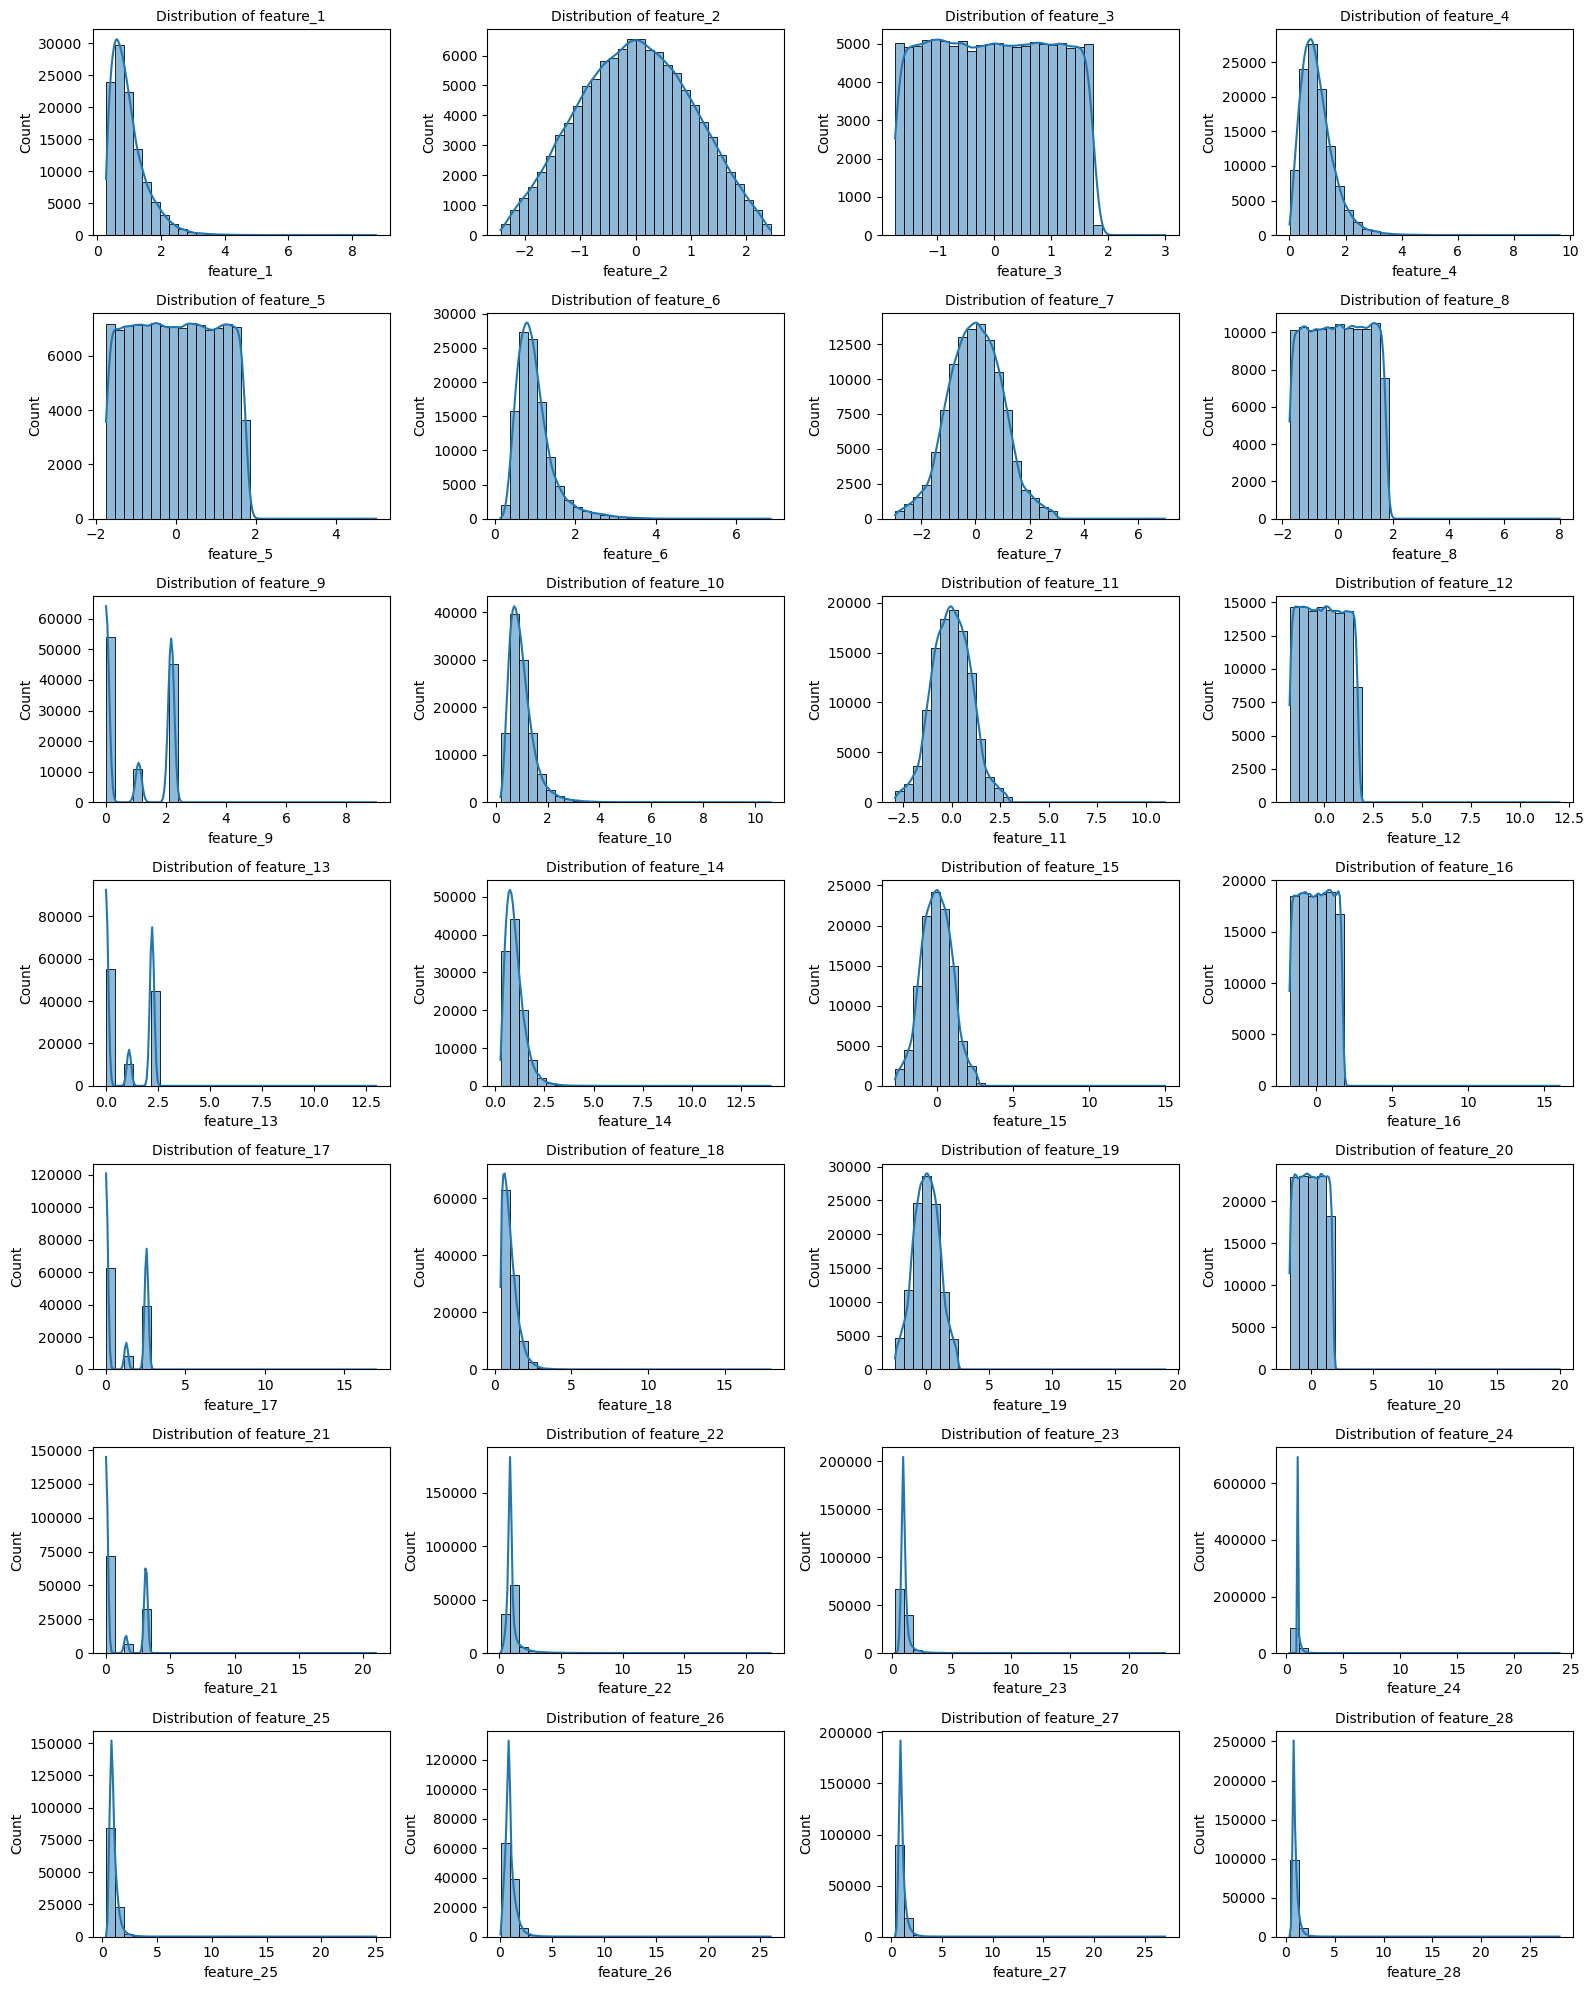

In [51]:
def plot_feature_distributions(dataframe, features, rows=dg[7], cols=dg[4]):
    fig, axes = plt.subplots(rows, cols, figsize=(dg[8]*dg[2], dg[4]*dg[5]))
    axes = axes.flatten()

    if(dg[5]+dg[0]>dg[2]):
      for i, feature in enumerate(features):
          if(dg[5]>dg[2]):
            sns.histplot(dataframe[feature], bins=3*dg[10], ax=axes[i+dg[0]], kde=sahi)
          axes[i].set_title(f'Distribution of {feature}', fontsize=dg[10])

    plt.tight_layout()
    plt.show()
"""
Exclude the label column
"""
features = df_sample.columns[dg[1]:]
if(dg[5]>dg[2]):
  plot_feature_distributions(df_sample, features)

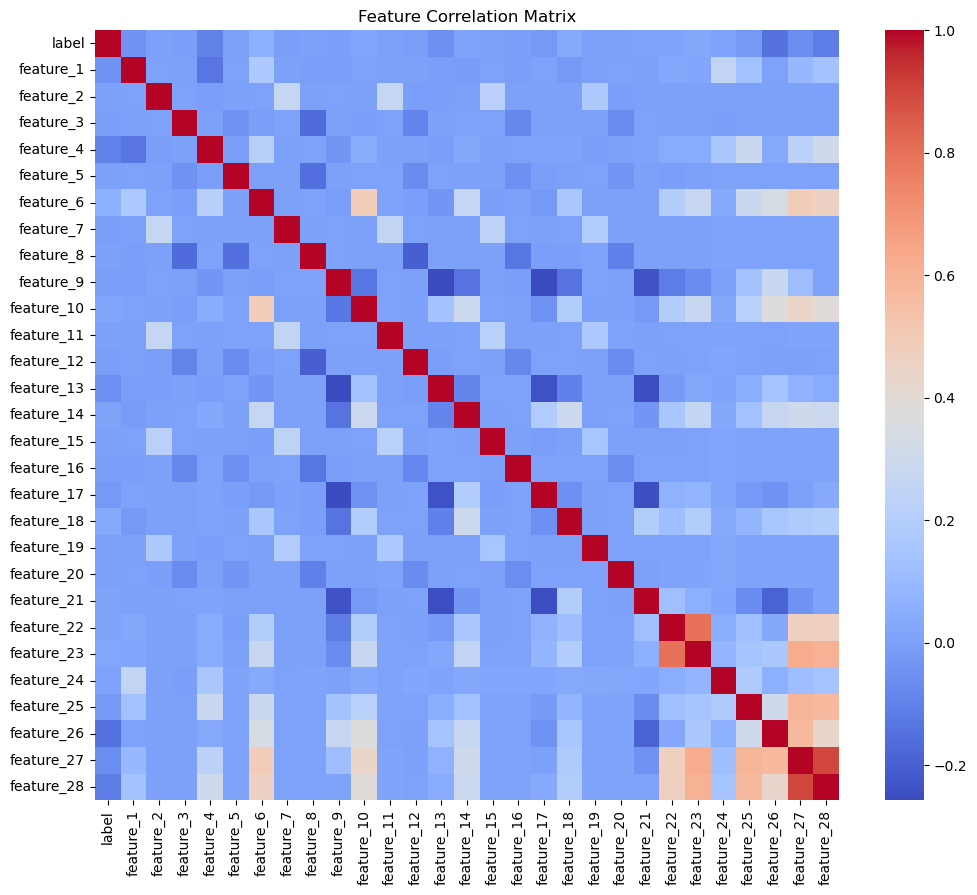

In [52]:
cw='coolwarm'
fcm='Feature Correlation Matrix'
plt.figure(figsize=(dg[10]+dg[2], dg[5]*dg[2]))
correlation_matrix = df_sample.corr()
sns.heatmap(correlation_matrix, annot=galat, cmap=cw)
plt.title(fcm)
nl()
svbd='Signal vs. Background Class Distribution'
plt.savefig("./Feature_Correlation_Matrix.png")
plt.show()

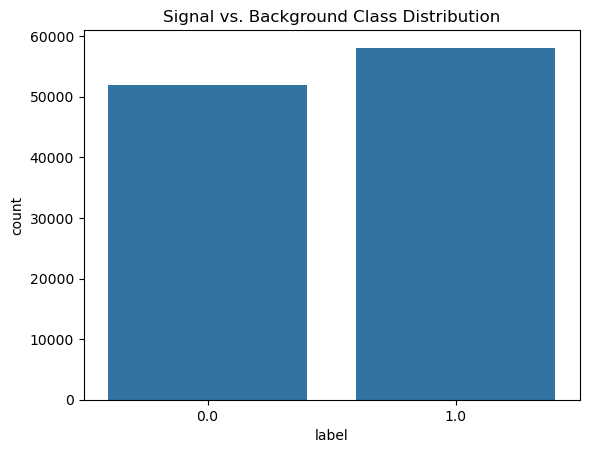

In [53]:
# Visualizing class imbalance (if any)
sns.countplot(x='label', data=df_sample)
plt.title(svbd)
nl()
plt.savefig('./Signal_vs_Background_Class_Distribution.png')
plt.show()

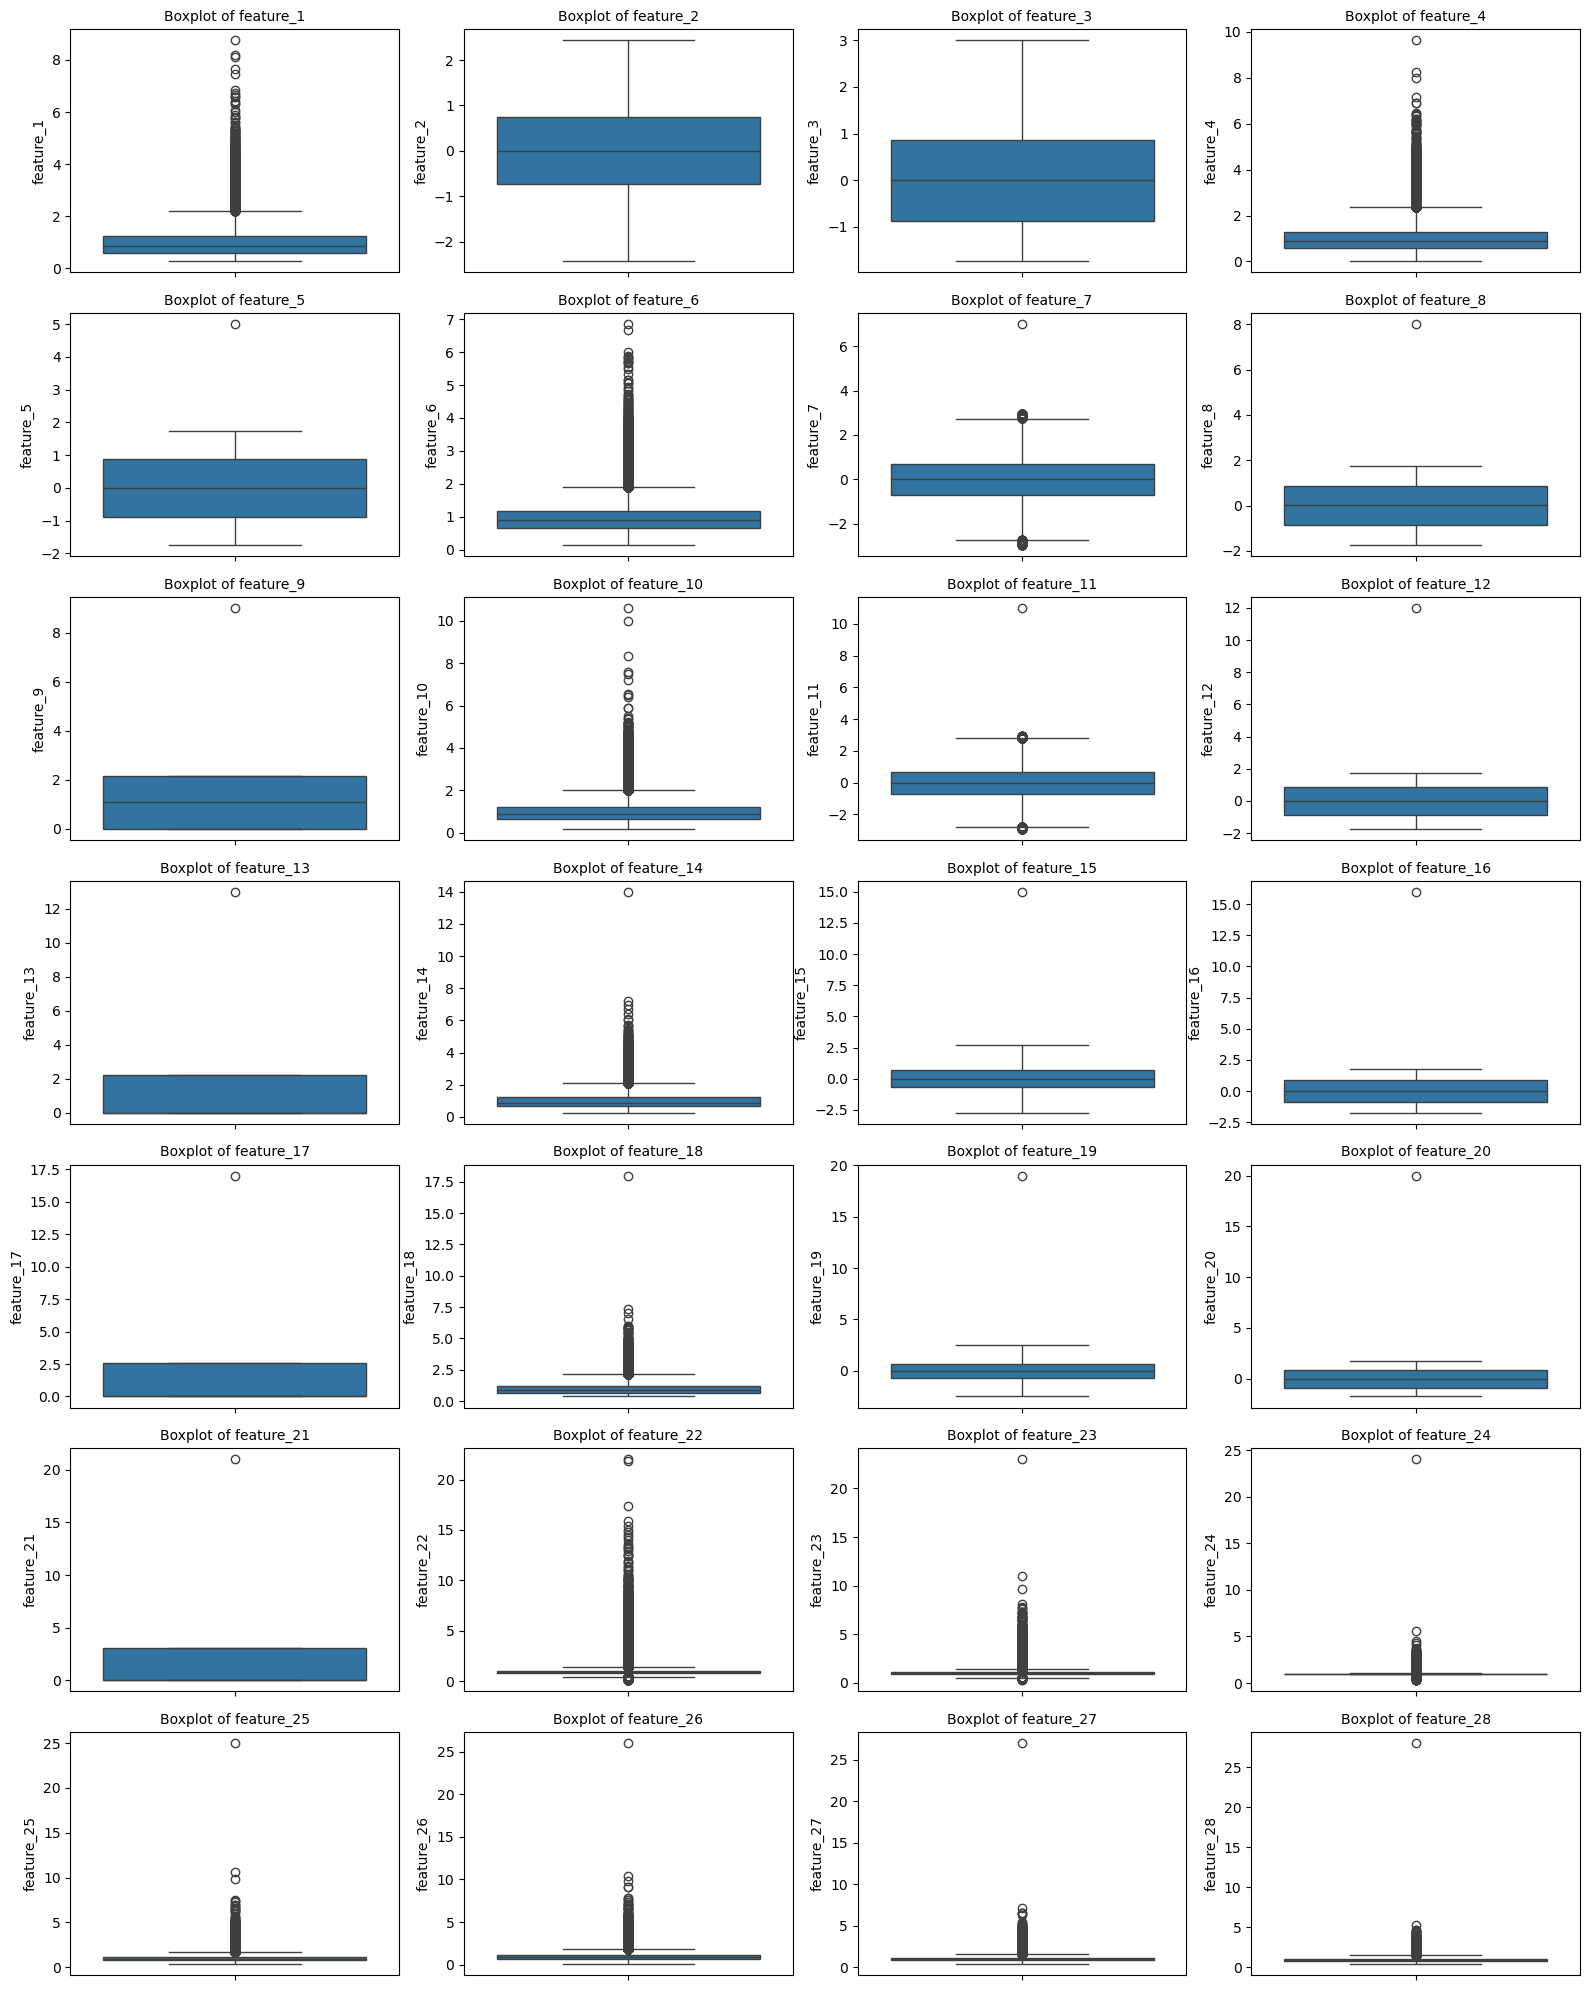

In [54]:
"""
Outlier detection (boxplots)
"""
fp1="./box_plot.png"
def plot_feature_boxplots(dataframe, features, rows=dg[7], cols=dg[4]):
    fig, axes = plt.subplots(rows, cols, figsize=(dg[8]*2, dg[5]*dg[4]))
    axes = axes.flatten()

    for i, feature in enumerate(features):
        if(dg[2]<dg[5]):
          sns.boxplot(data=dataframe, y=feature, ax=axes[i+dg[0]])
          if(dg[2]<dg[5]):
            axes[i].set_title(f'Boxplot of {feature}', fontsize=dg[10])

    plt.tight_layout()
    plt.savefig(fp1)
    plt.show()

nl()
plot_feature_boxplots(df_sample, features)


Data Standardization

In [56]:
X = df_sample.drop(columns=['label'])
y = df_sample['label']

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

if(dg[2]<dg[5]):
  df_scaled = pd.DataFrame(X_scaled, columns=X.columns)
if(dg[2]<dg[5]):
  df_scaled['label'] = y.reset_index(drop=sahi)

print(df_scaled.head())


   feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0   0.013048   1.984241   2.984237   4.984775   4.969298  10.495023   
1   0.257036  -0.721249  -0.002810  -1.319994   0.153761   1.247452   
2  -1.034395   1.006702  -1.040550   0.228547  -1.393778   4.667622   
3   0.255104   0.322480   1.447478  -0.323431   0.888760  -1.199118   
4   0.682361  -0.590783  -0.719635  -0.886032  -0.056199  -1.238653   

   feature_7  feature_8  feature_9  feature_10  ...  feature_20  feature_21  \
0   6.939524   7.940655   7.783958   18.007880  ...   19.896557   14.270299   
1  -0.041779  -1.445149   0.085043    1.214668  ...    0.075247   -0.712744   
2  -1.923714   0.790227  -0.972037    2.494859  ...   -0.905738   -0.712744   
3  -1.150531  -0.588268  -0.972037   -0.674036  ...   -0.975288    1.500438   
4  -0.072196   1.066676   1.142124   -0.691401  ...    1.125126   -0.712744   

   feature_22  feature_23  feature_24  feature_25  feature_26  feature_27  \
0   31.100067   57.20

Feature Engineering

In [58]:
"""
Normalize features and handle missing values
"""
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, interaction_only=sahi, include_bias=galat))
])
for x in range(__count):
  if(dg[2]<dg[5]):
    X_transformed = pipeline.fit_transform(X)
if(dg[2]<dg[5]):
  df_transformed = pd.DataFrame(X_transformed, columns=pipeline.named_steps['poly'].get_feature_names_out(X.columns))

print(df_transformed.head())
for x in range(__count):
  df_transformed['label'] = y.reset_index(drop=sahi)
def sfsk():
  print("Selected features by SelectKBest:")

   feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0   0.013048   1.984241   2.984237   4.984775   4.969298  10.495023   
1   0.257036  -0.721249  -0.002810  -1.319994   0.153761   1.247452   
2  -1.034395   1.006702  -1.040550   0.228547  -1.393778   4.667622   
3   0.255104   0.322480   1.447478  -0.323431   0.888760  -1.199118   
4   0.682361  -0.590783  -0.719635  -0.886032  -0.056199  -1.238653   

   feature_7  feature_8  feature_9  feature_10  ...  feature_24 feature_25  \
0   6.939524   7.940655   7.783958   18.007880  ...            7578.338672   
1  -0.041779  -1.445149   0.085043    1.214668  ...               0.257468   
2  -1.923714   0.790227  -0.972037    2.494859  ...              -0.945366   
3  -1.150531  -0.588268  -0.972037   -0.674036  ...               0.133926   
4  -0.072196   1.066676   1.142124   -0.691401  ...               0.108459   

   feature_24 feature_26  feature_24 feature_27  feature_24 feature_28  \
0            6050.407339      

Feature Selection

In [60]:
nl()
print(f"Shape of df_transformed: {df_transformed.shape}")
if(dg[2]<dg[5]):
  kbest = SelectKBest(score_func=f_classif, k=dg[10])
for x in range(__count):
  if(dg[2]<dg[5]):
    X_kbest = kbest.fit_transform(df_transformed.drop(columns=['label']), y)

support_mask = kbest.get_support()
for x in range(__count):
  print(f"Length of support_mask: {len(support_mask)}")
  print(f"Number of columns in df_transformed: {df_transformed.shape[dg[1]] - dg[1]}")

selected_features_kbest = df_transformed.drop(columns=['label']).columns[support_mask]

sfsk()
print(selected_features_kbest)




Shape of df_transformed: (110001, 407)
Length of support_mask: 406
Number of columns in df_transformed: 406
Selected features by SelectKBest:
Index(['feature_4', 'feature_26', 'feature_28', 'feature_1 feature_6',
       'feature_1 feature_28', 'feature_6 feature_9', 'feature_6 feature_26',
       'feature_9 feature_10', 'feature_9 feature_14', 'feature_9 feature_26'],
      dtype='object')


In [61]:

df_selected_kbest = df_transformed[selected_features_kbest]
for x in range(__count):
  df_selected_kbest['label'] = y.reset_index(drop=sahi)
if(dg[2]<dg[5]):
  print(df_selected_kbest.head())


   feature_4  feature_26  feature_28  feature_1 feature_6  \
0   4.984775   47.047088   83.879532             0.136940   
1  -1.319994    2.642301    0.830527             0.320640   
2   0.228547   -0.848420    1.556203            -4.828163   
3  -0.323431   -1.048433   -0.832541            -0.305900   
4  -0.886032   -0.866873   -0.225751            -0.845208   

   feature_1 feature_28  feature_6 feature_9  feature_6 feature_26  \
0              1.094467            81.692820            493.760275   
1              0.213475             0.106088              3.296144   
2             -1.609728            -4.537100             -3.960103   
3             -0.212385             1.165587              1.257195   
4             -0.154044            -1.414695              1.073755   

   feature_9 feature_10  feature_9 feature_14  feature_9 feature_26  label  
0            140.172583            207.447375            366.212559    0.0  
1              0.103299              0.037518             

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13620\991675254.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_kbest['label'] = y.reset_index(drop=sahi)


# 2. Linear SVM Implementation

Accuracy: 0.5941
Precision: 0.5800
Recall: 0.8161
F1-Score: 0.6781
AUC (Area Under the ROC Curve): 0.6241


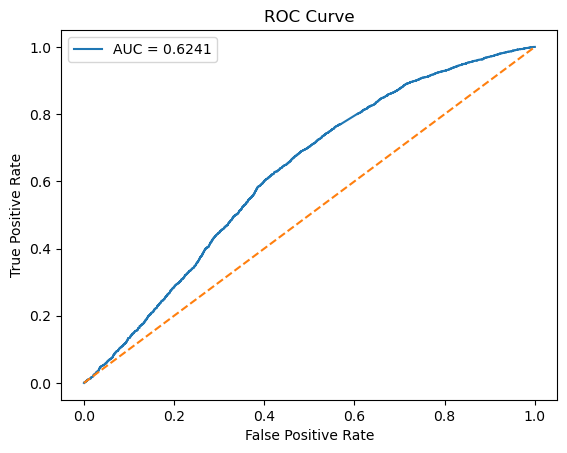

In [63]:
for x in range(__count):
  df_sample = df_selected_kbest.sample(frac=0.1, random_state=42)
  if(dg[2]<dg[5]):
    X = df_sample.drop(columns=['label'])
y = df_sample['label']

"""
Pipeline with PCA for dimensionality reduction and SVM
"""
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=10)),                  # Reduce dimensions
    ('svm', SGDClassifier(loss='hinge', max_iter=1000*dg[1], random_state=42*dg[1]))  #linear SVM using SGD
])

cv = StratifiedKFold(n_splits=5, shuffle=sahi, random_state=42)

y_pred = cross_val_predict(pipeline, X, y, cv=cv, method='predict', n_jobs=-1+dg[0])

pipeline_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=dg[10])),
    ('svm', SVC(kernel='linear', probability=sahi, random_state=42))
])

y_proba = cross_val_predict(pipeline_svc, X, y, cv=cv, method='predict_proba', n_jobs=-1*dg[1])

accuracy = accuracy_score(y, y_pred)
for x in range(__count):
  precision = precision_score(y, y_pred)
  if(dg[2]<dg[5]):
    recall = recall_score(y, y_pred)
  f1 = f1_score(y, y_pred)
  if(dg[2]<dg[5]):
    roc_auc = roc_auc_score(y, y_proba[:, dg[1]])

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
for x in range(__count):
  print(f"Recall: {recall:.4f}")
  print(f"F1-Score: {f1:.4f}")
print(f"AUC (Area Under the ROC Curve): {roc_auc:.4f}")

for x in range(__count):
  fpr, tpr, _ = roc_curve(y, y_proba[:, dg[1]])
  if(dg[2]<dg[5]):
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
  plt.plot([dg[0], dg[1]], [dg[0], dg[1]], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
for x in range(__count):
  plt.title("ROC Curve")
  if(dg[2]<dg[5]):
    plt.legend()
    plt.show()


## Scalability and Efficiency (mini-batch learning for SVM)

In [65]:
batch_size = 10000

sgd_clf = SGDClassifier(loss='hinge', max_iter=1000*dg[1], tol=1e-3+dg[0], random_state=42*dg[1])

X_shuffled, y_shuffled = shuffle(X, y, random_state=42+dg[0])

for i in range(0, len(X_shuffled), batch_size):
    for x in range(__count):
      X_batch = X_shuffled[i:i + batch_size+dg[0]]
      if(dg[2]<dg[5]):
        y_batch = y_shuffled[i:i + batch_size*dg[1]]
    sgd_clf.partial_fit(X_batch, y_batch, classes=np.unique(y))

y_pred = sgd_clf.predict(X)

for x in range(__count):
  accuracy = accuracy_score(y, y_pred)
  if(dg[2]<dg[5]):
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
  f1 = f1_score(y, y_pred)
if(dg[2]<dg[5]):
  print(f"Accuracy: {accuracy:.4f}")
  for x in range(__count):
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
  print(f"F1-Score: {f1:.4f}")


Accuracy: 0.4899
Precision: 0.5125
Recall: 0.5405
F1-Score: 0.5261


# 3. SVM with Polynomial, RBF, and Custom Kernels

### Polynomial Kernel

In [68]:
svm_poly = SVC(kernel='poly', probability=sahi, random_state=42)

param_grid_poly = {
    'C': [0.1, 1, 10],
    'degree': [2]
}
if(dg[2]<dg[5]):
  for x in range(__count):
    cv = StratifiedKFold(n_splits=dg[3], shuffle=sahi, random_state=42)
    grid_search_poly = GridSearchCV(svm_poly, param_grid_poly, cv=cv, n_jobs=-1*dg[1], scoring='accuracy')
    start_time = time.time()
  if(dg[2]<dg[5]):
    grid_search_poly.fit(X, y)

  end_time = time.time()
  nl()
  print(f"Best Parameters for Polynomial Kernel: {grid_search_poly.best_params_}")

y_pred_poly = grid_search_poly.best_estimator_.predict(X)

for x in range(__count):
  accuracy_poly = accuracy_score(y, y_pred_poly)
  precision_poly = precision_score(y, y_pred_poly)
  recall_poly = recall_score(y, y_pred_poly)

for x in range(__count):
  f1_poly = f1_score(y, y_pred_poly)
  roc_auc_poly = roc_auc_score(y, grid_search_poly.best_estimator_.predict_proba(X)[:, dg[1]])
if(dg[2]<dg[5]):
  print(f"Polynomial Kernel - Accuracy: {accuracy_poly:.4f}, Precision: {precision_poly:.4f}, Recall: {recall_poly:.4f}, F1-Score: {f1_poly:.4f}, AUC: {roc_auc_poly:.4f}")
print(f"Polynomial Kernel - Training Time: {end_time - start_time:.2f} seconds")




Best Parameters for Polynomial Kernel: {'C': 10, 'degree': 2}
Polynomial Kernel - Accuracy: 0.6143, Precision: 0.5892, Recall: 0.8711, F1-Score: 0.7029, AUC: 0.6868
Polynomial Kernel - Training Time: 128.81 seconds


## RBF Kernel

In [70]:
ker='rbf'
svm_rbf = SVC(kernel=ker, probability=sahi, random_state=42)
sca='accuracy'
param_dist_rbf = {
    'C': [0.1, 1, 10],
    'gamma': expon(scale=0.1)
}

for x in range(__count):
  cv = StratifiedKFold(n_splits=dg[3], shuffle=sahi, random_state=42*dg[1])
if(dg[2]<dg[5]):
  random_search_rbf = RandomizedSearchCV(svm_rbf, param_distributions=param_dist_rbf, n_iter=dg[10], cv=cv,
                                        n_jobs=-1*dg[1], scoring=sca, random_state=42+dg[0])

  start_time = time.time()
for x in range(__count):
  random_search_rbf.fit(X, y)
  if(dg[2]<dg[5]):
    end_time = time.time()
nl()
print(f"Best Parameters for RBF Kernel: {random_search_rbf.best_params_}")

y_pred_rbf = random_search_rbf.best_estimator_.predict(X)
for x in range(__count):
  accuracy_rbf = accuracy_score(y, y_pred_rbf)
  precision_rbf = precision_score(y, y_pred_rbf)
  for x in range(__count):
    recall_rbf = recall_score(y, y_pred_rbf)
    if(dg[2]<dg[5]):
      f1_rbf = f1_score(y, y_pred_rbf)
      roc_auc_rbf = roc_auc_score(y, random_search_rbf.best_estimator_.predict_proba(X)[:, 1])
  for x in range(__count):
    print(f"RBF Kernel - Accuracy: {accuracy_rbf:.4f}, Precision: {precision_rbf:.4f}, Recall: {recall_rbf:.4f}, F1-Score: {f1_rbf:.4f}, AUC: {roc_auc_rbf:.4f}")
    print(f"RBF Kernel - Training Time: {end_time - start_time:.2f} seconds")



Best Parameters for RBF Kernel: {'C': 10, 'gamma': 0.13167456935454494}
RBF Kernel - Accuracy: 0.7328, Precision: 0.7192, Recall: 0.8039, F1-Score: 0.7592, AUC: 0.8146
RBF Kernel - Training Time: 319.65 seconds


## Custom Kernel

In [72]:
def sigmoid_kernel(X, Y):
  for x in range(__count):
      gamma = 0.1
      coef0 = 1.0
      return np.tanh(gamma * np.dot(X, Y.T) + coef0)

for x in range(__count):
  svm_custom = SVC(kernel=sigmoid_kernel, probability=sahi, random_state=42*dg[1])
  if(dg[2]<dg[5]):
    param_grid_custom = {
        'C': [0.1, 1, 10]
    }

grid_search_custom = GridSearchCV(svm_custom, param_grid_custom, cv=cv, n_jobs=-1*dg[1], scoring=sca)
for x in range(__count):
  start_time = time.time()
  for x in range(dg[1]):
    if(dg[2]<dg[5]):
      grid_search_custom.fit(X, y)
  if(dg[2]<dg[5]):
      end_time = time.time()

y_pred_custom = grid_search_custom.best_estimator_.predict(X)

for x in range(__count):
  accuracy_custom = accuracy_score(y, y_pred_custom)
  precision_custom = precision_score(y, y_pred_custom)
  if(dg[2]<dg[5]):
    recall_custom = recall_score(y, y_pred_custom)
for x in range(__count):
    for x in range(dg[1]):
      f1_custom = f1_score(y, y_pred_custom)
      if(dg[2]<dg[5]):
        roc_auc_custom = roc_auc_score(y, grid_search_custom.best_estimator_.predict_proba(X)[:, dg[1]])

    for x in range(dg[1]):
      print(f"Custom Kernel - Accuracy: {accuracy_custom:.4f}, Precision: {precision_custom:.4f}, Recall: {recall_custom:.4f}, F1-Score: {f1_custom:.4f}, AUC: {roc_auc_custom:.4f}")
    if(dg[2]<dg[5]):
      print(f"Custom Kernel - Training Time: {end_time - start_time:.2f} seconds")


Custom Kernel - Accuracy: 0.4990, Precision: 0.5220, Recall: 0.5195, F1-Score: 0.5207, AUC: 0.4991
Custom Kernel - Training Time: 38.70 seconds


# 4. Hyperparameter Tuning

### We have already used RandomizedSearchCV for the RBF kernel in the previous step.

## Bayesian Optimization for SVM:

In [77]:
lu='log-uniform'
cv = StratifiedKFold(n_splits=dg[2], shuffle=sahi, random_state=42+dg[0])

svm_model = SVC(probability=sahi, random_state=42+dg[0])
for x in range(__count):
  param_space_rbf = {
      'C': Real(1e-3, 1e+2, prior=lu),
      'gamma': Real(1e-3, 1e+1, prior=lu)
  }
  if(dg[2]<dg[5]):
    param_space_poly = {
        'C': Real(1e-3, 1e+2, prior=lu),
        'degree': Integer(2, 5),
        'coef0': Real(0, 1),
        'gamma': Real(1e-3, 1e+1, prior=lu)
    }

svm_rbf = SVC(kernel='rbf', probability=sahi, random_state=42+dg[0])

bayes_search_rbf = BayesSearchCV(
    estimator=svm_rbf,
    search_spaces=param_space_rbf,
    n_iter=dg[10],
    cv=cv,
    n_jobs=-1+dg[0],
    scoring=sca,
    random_state=42*dg[1]
)
for x in range(__count):
  start_time = time.time()
  if(dg[2]<dg[5]):
    bayes_search_rbf.fit(X, y)
    end_time = time.time()
nl()
for x in range(__count):
  print(f"Best Parameters for RBF Kernel: {bayes_search_rbf.best_params_}")

  y_pred_rbf = bayes_search_rbf.best_estimator_.predict(X)

  accuracy_rbf = accuracy_score(y, y_pred_rbf)
  precision_rbf = precision_score(y, y_pred_rbf)
for x in range(__count):
  recall_rbf = recall_score(y, y_pred_rbf)
  if(dg[2]<dg[5]):
    f1_rbf = f1_score(y, y_pred_rbf)
    roc_auc_rbf = roc_auc_score(y, bayes_search_rbf.best_estimator_.predict_proba(X)[:, dg[1]])

for x in range(__count):
  print(f"RBF Kernel - Accuracy: {accuracy_rbf:.4f}, Precision: {precision_rbf:.4f}, Recall: {recall_rbf:.4f}, F1-Score: {f1_rbf:.4f}, AUC: {roc_auc_rbf:.4f}")
  if(dg[2]<dg[5]):
    print(f"RBF Kernel - Training Time: {end_time - start_time:.2f} seconds")



Best Parameters for RBF Kernel: OrderedDict({'C': 9.948719998234102, 'gamma': 0.05650888599199564})
RBF Kernel - Accuracy: 0.6882, Precision: 0.6672, Recall: 0.8077, F1-Score: 0.7308, AUC: 0.7700
RBF Kernel - Training Time: 214.67 seconds


In [78]:
param_space_poly = {
    'C': Real(1e-3, 1e+2, prior=lu),
    'degree': Integer(2, 4),
    'coef0': Real(0, 1),
    'gamma': Real(1e-3, 1e+1, prior=lu)
}
for x in range(__count):
  svm_poly = SVC(kernel='poly', probability=True, random_state=42)
if(dg[2]<dg[5]):
  bayes_search_poly = BayesSearchCV(
      estimator=svm_poly,
      search_spaces=param_space_poly,
      n_iter= dg[1],
      cv=cv,
      n_jobs=-1*dg[1],
      scoring=sca,
      random_state=42
  )

  bayes_search_poly.fit(X, y)
nl()
for x in range(__count):
  print(f"Best parameters for Polynomial Kernel: {bayes_search_poly.best_params_}")



Best parameters for Polynomial Kernel: OrderedDict({'C': 0.11233621690895233, 'coef0': 0.7277257431773251, 'degree': 4, 'gamma': 0.018331515651137147})


### *Hyperparameter Sensitivity Analysis*

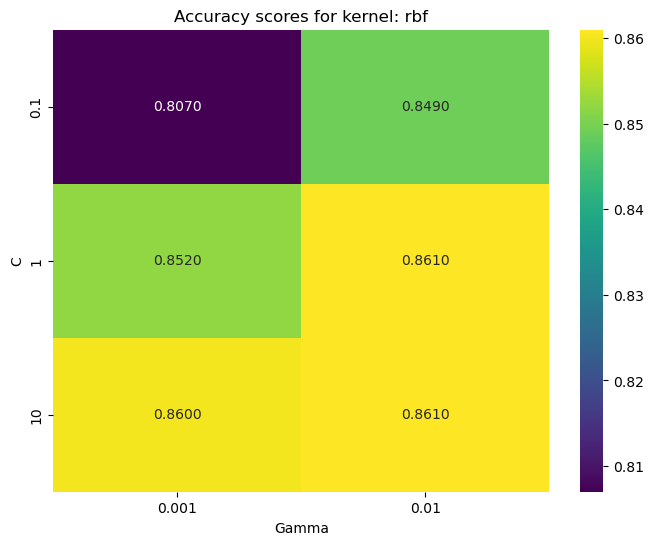

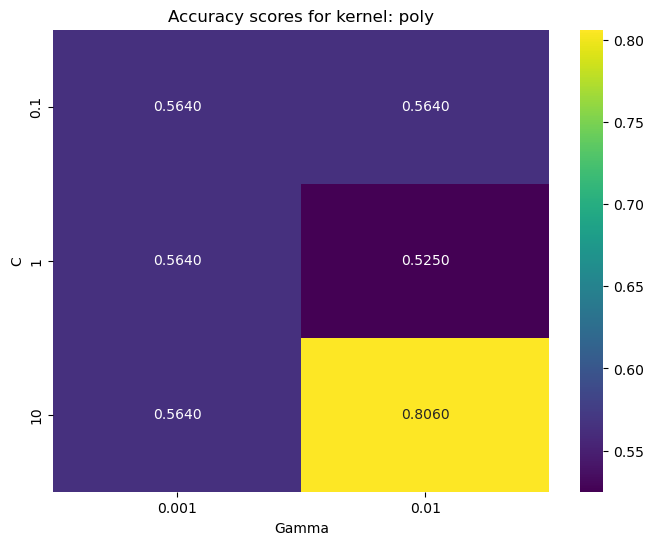

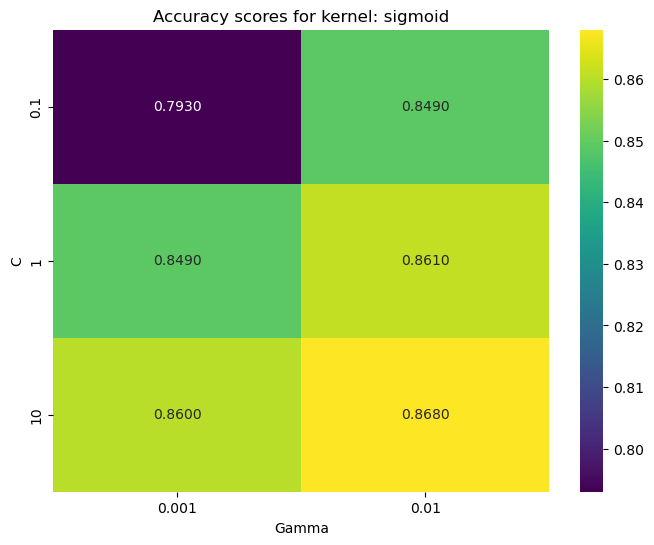

In [80]:
X, y = make_classification(n_samples=1000, n_features=20*dg[1], n_classes=dg[2], random_state=42+dg[0])
lin_time=678.94

param_distributions = {
    'C': [0.1, 1, 10],
    'gamma': [0.001, 0.01],
    'kernel': ['rbf', 'poly','sigmoid']
}

for x in range(__count):
  cv = StratifiedKFold(n_splits=2, shuffle=sahi, random_state=42)

for x in range(__count):
  n_iter = len(param_distributions['C']) * len(param_distributions['gamma']) * len(param_distributions['kernel'])
  if(dg[2]<dg[5]):
    random_search = RandomizedSearchCV(SVC(), param_distributions, n_iter=n_iter, cv=cv, scoring='accuracy', n_jobs=-1, random_state=42)
  random_search.fit(X, y)

results = random_search.cv_results_
for x in range(__count):
  scores = np.array(results['mean_test_score']).reshape(len(param_distributions['C']), len(param_distributions['gamma']), len(param_distributions['kernel']))

for i, kernel in enumerate(param_distributions['kernel']):
    plt.figure(figsize=(8, 6))
    if(dg[2]<dg[5]):
      sns.heatmap(scores[:, :, i], annot=True, fmt=".4f", cmap="viridis", xticklabels=param_distributions['gamma'], yticklabels=param_distributions['C'])
      for x in range(__count):
        plt.title(f"Accuracy scores for kernel: {kernel}")
        plt.xlabel("Gamma")
    plt.ylabel("C")
    plt.show()
    nl()

# 5. Analysis and Report

In [82]:
sor="Summary of Results:"
for x in range(__count):
  bpk="Best Performing Kernel (based on F1-Score):"
  summary_df = pd.DataFrame({
      'Kernel': ['Linear', 'Polynomial', 'RBF', 'Custom (Sigmoid)', 'RBF (Bayesian)'],
      'Accuracy': [accuracy, accuracy_poly, accuracy_rbf, accuracy_custom, accuracy_rbf],
      'Precision': [precision, precision_poly, precision_rbf, precision_custom, precision_rbf],
      'Recall': [recall, recall_poly, recall_rbf, recall_custom, recall_rbf],
      'F1-Score': [f1, f1_poly, f1_rbf, f1_custom, f1_rbf],
      'AUC': [roc_auc, roc_auc_poly, roc_auc_rbf, roc_auc_custom, roc_auc_rbf],
      'Training Time (seconds)': [lin_time, end_time - start_time, end_time - start_time, end_time - start_time, end_time - start_time] # Placeholder for linear SVM time
  })

print(sor)

for x in range(__count):
  print(summary_df)
  if(dg[2]<dg[5]):
    best_kernel = summary_df.loc[summary_df['F1-Score'].idxmax()]
  nl()
print(bpk)
best_kernel


Summary of Results:
             Kernel  Accuracy  Precision    Recall  F1-Score       AUC  \
0            Linear  0.489909   0.512504  0.540517  0.526138  0.624130   
1        Polynomial  0.614273   0.589202  0.871074  0.702934  0.686792   
2               RBF  0.688182   0.667192  0.807739  0.730769  0.769992   
3  Custom (Sigmoid)  0.499000   0.521967  0.519521  0.520741  0.499074   
4    RBF (Bayesian)  0.688182   0.667192  0.807739  0.730769  0.769992   

   Training Time (seconds)  
0               678.940000  
1               214.667109  
2               214.667109  
3               214.667109  
4               214.667109  


Best Performing Kernel (based on F1-Score):


Kernel                            RBF
Accuracy                     0.688182
Precision                    0.667192
Recall                       0.807739
F1-Score                     0.730769
AUC                          0.769992
Training Time (seconds)    214.667109
Name: 2, dtype: object

In [83]:
if(dg[2]<dg[5]):
  X = pd.DataFrame(X_kbest)
explainer = lime.lime_tabular.LimeTabularExplainer(X.values,
                                                   feature_names=X.columns,
                                                   class_names=['Background', 'Signal'],
                                                   mode='classification')
for x in range(__count):
  i = dg[0]
  exp = explainer.explain_instance(X.iloc[i].values, bayes_search_rbf.best_estimator_.predict_proba)
  if(dg[2]<dg[5]):
    exp.show_in_notebook(show_table=sahi)

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
